In this notebook I use a simpler model than Xception, which I got from the deep lizard tutorial here:https://www.youtube.com/watch?v=3V9YFPfgyAY&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=12&t=217s

I will use the cleaner training set. The purpose is to compare the model performance to the Xception model.  

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix


## Generate a keras Dataset

In [2]:
data_fld = '/home/ahoag/ML/mars/attempt2/images_for_cnn'

In [3]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_fld,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    class_names=['no_craters','craters']
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_fld,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    class_names=['no_craters','craters']
)

Found 1500 files belonging to 2 classes.
Using 1200 files for training.
Found 1500 files belonging to 2 classes.
Using 300 files for validation.


## Visualize the data

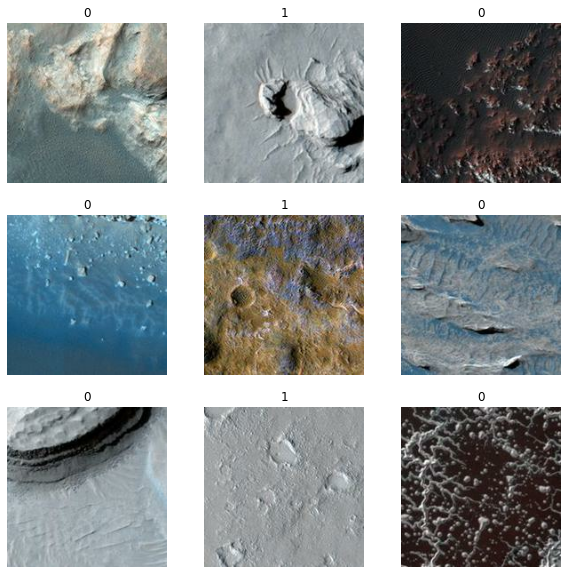

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): # Take grabs items at the batch level
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Configure the dataset for performance

In [5]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## Build a model

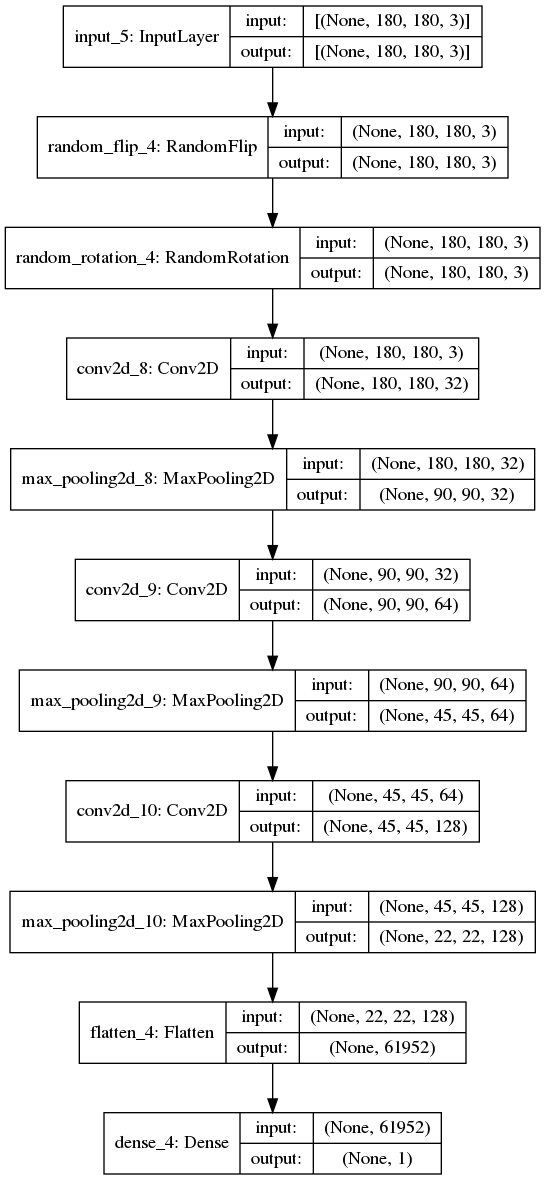

In [15]:
def make_model(input_shape):
    # data_augmentation
    inputs = keras.Input(shape=input_shape)
    x = layers.experimental.preprocessing.RandomFlip("horizontal")(inputs)
    x = layers.experimental.preprocessing.RandomRotation(0.1)(x)
    x = layers.Conv2D(32, 3, padding="same",activation='relu',input_shape=input_shape)(x)
    x = layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    x = layers.Conv2D(64, 3,padding="same",activation='relu')(x)
    x = layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    x = layers.Conv2D(128, 3,padding="same",activation='relu')(x)
    x = layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    x = layers.Flatten()(x)
            
    outputs = layers.Dense(units=1,activation='sigmoid')(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,))
keras.utils.plot_model(model, show_shapes=True)

In [16]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
random_flip_4 (RandomFlip)   (None, 180, 180, 3)       0         
_________________________________________________________________
random_rotation_4 (RandomRot (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 45, 45, 64)        0   

## Train the model

In [17]:
epochs = 40

callbacks = [
    keras.callbacks.ModelCheckpoint("/home/ahoag/ML/mars/simple_model3/cnn_saved_epochs/save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/40
38/38 [==============================] - 15s 375ms/step - loss: 33.7543 - accuracy: 0.5179 - val_loss: 0.6963 - val_accuracy: 0.4967
Epoch 2/40
38/38 [==============================] - 15s 381ms/step - loss: 0.6957 - accuracy: 0.5385 - val_loss: 0.6871 - val_accuracy: 0.5400
Epoch 3/40
38/38 [==============================] - 14s 371ms/step - loss: 0.7842 - accuracy: 0.5331 - val_loss: 0.6909 - val_accuracy: 0.5133
Epoch 4/40
38/38 [==============================] - 15s 379ms/step - loss: 0.6876 - accuracy: 0.5677 - val_loss: 0.6768 - val_accuracy: 0.5367
Epoch 5/40
38/38 [==============================] - 14s 372ms/step - loss: 0.6808 - accuracy: 0.5424 - val_loss: 0.6694 - val_accuracy: 0.5433
Epoch 6/40
38/38 [==============================] - 14s 371ms/step - loss: 0.6889 - accuracy: 0.5331 - val_loss: 0.6935 - val_accuracy: 0.5200
Epoch 7/40
38/38 [==============================] - 15s 381ms/step - loss: 0.6876 - accuracy: 0.5403 - val_loss: 0.6845 - val_accuracy: 0.506

KeyboardInterrupt: 

## Evaluate the model

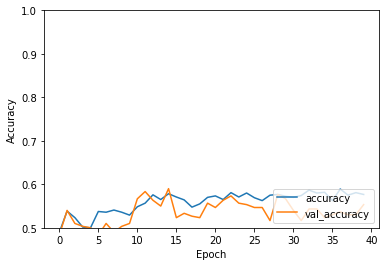

In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

Model stops learning after ~15 epochs. Overfitting isn't even an issue here

## Run inference on new data
Note that data augmentation and dropout are inactive at inference time.

In [13]:
test_fld = '/home/ahoag/ML/mars/attempt2/test_cnn'

These all look good! I think this is working! Maybe coincidence so we will want to make a more thorough test set. 

In [16]:
max_val_acc = max(history.history['val_accuracy'])
history.history['val_accuracy'].index(max_val_acc)+1 

60

## Evaluate model (at final) on test set

In [17]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_fld,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    class_names=['no_craters','craters']
)


Found 304 files belonging to 2 classes.


i=0,label=1
i=1,label=0
i=2,label=1
i=3,label=1
i=4,label=1
i=5,label=0
i=6,label=0
i=7,label=0
i=8,label=0


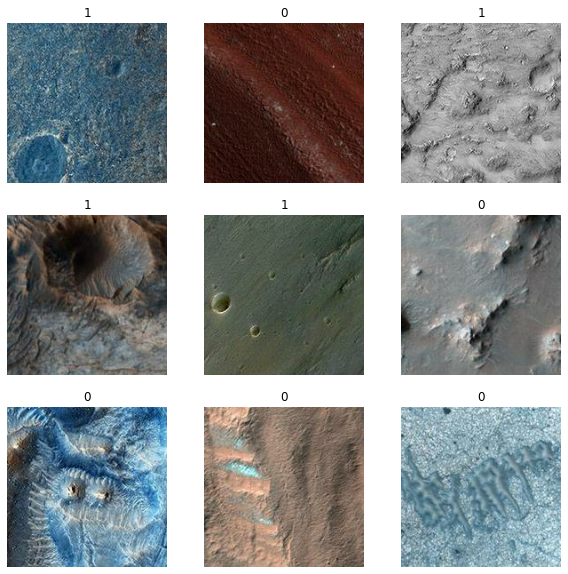

In [18]:
# Take a look at some of these to make sure they were loaded in right
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        print(f"i={i},label={labels[i]}")
        ax = plt.subplot(3, 3, i + 1)
#         ax.set_title(i)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [19]:
# Load in test images and labels
result = model.evaluate(test_ds)

10/10 [==============================] - 3s 274ms/step - loss: 0.2859 - accuracy: 0.8882


Looks like my test-set accuracy is ~88%. This is super good! Let's look at confusion matrix

In [20]:
test_predictions = []
test_labels = []
test_probs = []
for x, y in test_ds:
    new_predictions = model.predict(x)[:,0]
    test_predictions.extend(list(map(round,new_predictions)))
    test_labels.extend(list(map(round,y.numpy())))
    new_labels = list(map(round,y.numpy()))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        test_probs.append(pred_float)
    

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Normalized confusion matrix
[[0.94       0.06      ]
 [0.16233766 0.83766234]]


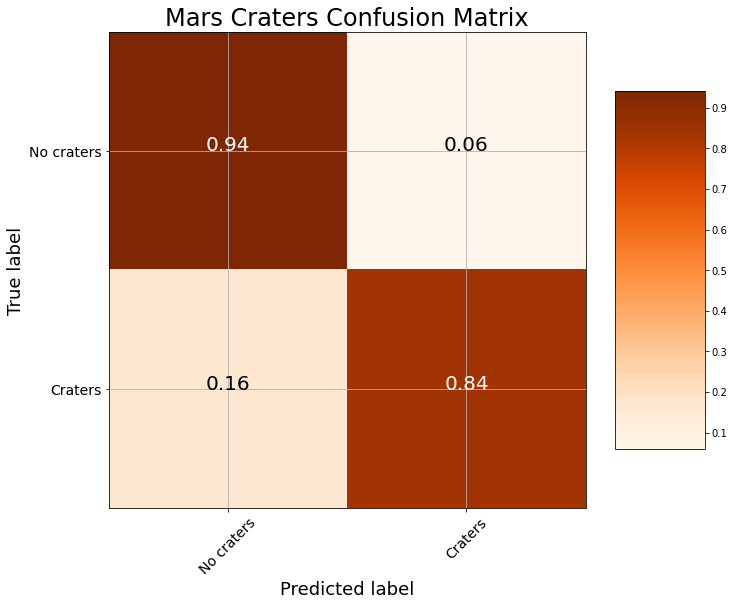

In [22]:
cm = confusion_matrix(test_labels, test_predictions)
plot_confusion_matrix(cm, classes = ['No craters', 'Craters'],
                      title = 'Mars Craters Confusion Matrix',
                     normalize=True)

Like the initial model, this model is very good at identifying what is NOT a crater. It has a harder time picking up all of the craters. Another way of saying this is the precision is very good but recall not as good. Let's compare ROC AUC curve to previous model.

In [26]:
train_predictions = []
train_labels = []
train_probs = []
for x, y in train_ds:
    new_predictions = model.predict(x)[:,0]
    train_predictions.extend(list(map(round,new_predictions)))
    train_labels.extend(list(map(round,y.numpy())))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        train_probs.append(pred_float)
    


In [42]:
previous_model_save_file = '../cnn_saved_epochs/best_model_epoch53.h5'
previous_model = keras.models.load_model(previous_model_save_file)

In [44]:
prevmodel_test_fld = '../test_set_attempt1'
prevmodel_test_ds = tf.keras.preprocessing.image_dataset_from_directory(prevmodel_test_fld,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    class_names=['no_craters','craters']
)

Found 419 files belonging to 2 classes.


In [45]:
prevmodel_test_predictions = []
prevmodel_test_labels = []
prevmodel_test_probs = []
for x, y in prevmodel_test_ds:
    new_predictions = previous_model.predict(x)[:,0]
    prevmodel_test_predictions.extend(list(map(round,new_predictions)))
    prevmodel_test_labels.extend(list(map(round,y.numpy())))
    new_labels = list(map(round,y.numpy()))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        prevmodel_test_probs.append(pred_float)

In [50]:
def evaluate_model(predictions, probs, train_predictions, train_probs,prevmodel_predictions,prevmodel_probs):
    """
    Compare machine learning model to baseline and previous model performance.
    Computes statistics and shows ROC curve.
    ---INPUT---
    predictions:    predicted classes in the test set
    
    """
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    previous = {}
    
    previous['recall'] = recall_score(prevmodel_test_labels, [1 for _ in range(len(prevmodel_test_labels))])
    previous['precision'] = precision_score(prevmodel_test_labels, [1 for _ in range(len(prevmodel_test_labels))])
    previous['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)}'
              f' Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    prevmodel_fpr, prevmodel_tpr, _ = roc_curve(prevmodel_test_labels, prevmodel_probs)
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(prevmodel_fpr, prevmodel_tpr, 'g', label = 'model1 (lg train set, quick data)')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model2 (sm, train set, good data)' )
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

Recall Baseline: 1.0 Test: 0.84 Train: 0.96
Precision Baseline: 0.51 Test: 0.93 Train: 0.97
Roc Baseline: 0.5 Test: 0.95 Train: 0.99


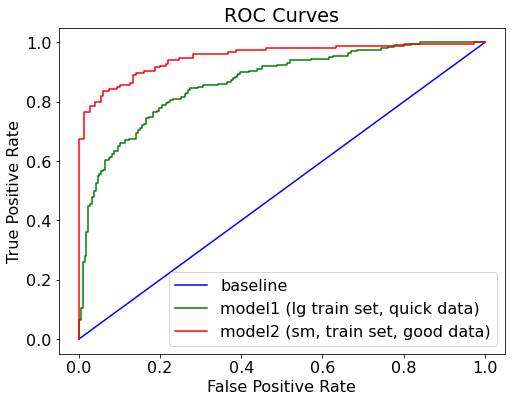

In [51]:
evaluate_model(test_predictions,test_probs,train_predictions, train_probs,
              prevmodel_test_predictions,prevmodel_test_probs)

In [211]:
false_negatives = [] # will be a list of dictionaries with 
# each dictionary being: {'image':numpy array of the image,'pred':floating point prediction between 0 and 1}

for x, y in test_ds: # loop over batches
    new_predictions = best_model.predict(x)[:,0]
    new_labels = list(map(round,y.numpy()))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        pred_binary = round(pred_float)
        truth = new_labels[ii]
        if truth == 1 and pred_binary == 0:
            fn_dict = {'image':x[ii],'pred':pred_float}
            false_negatives.append(fn_dict)


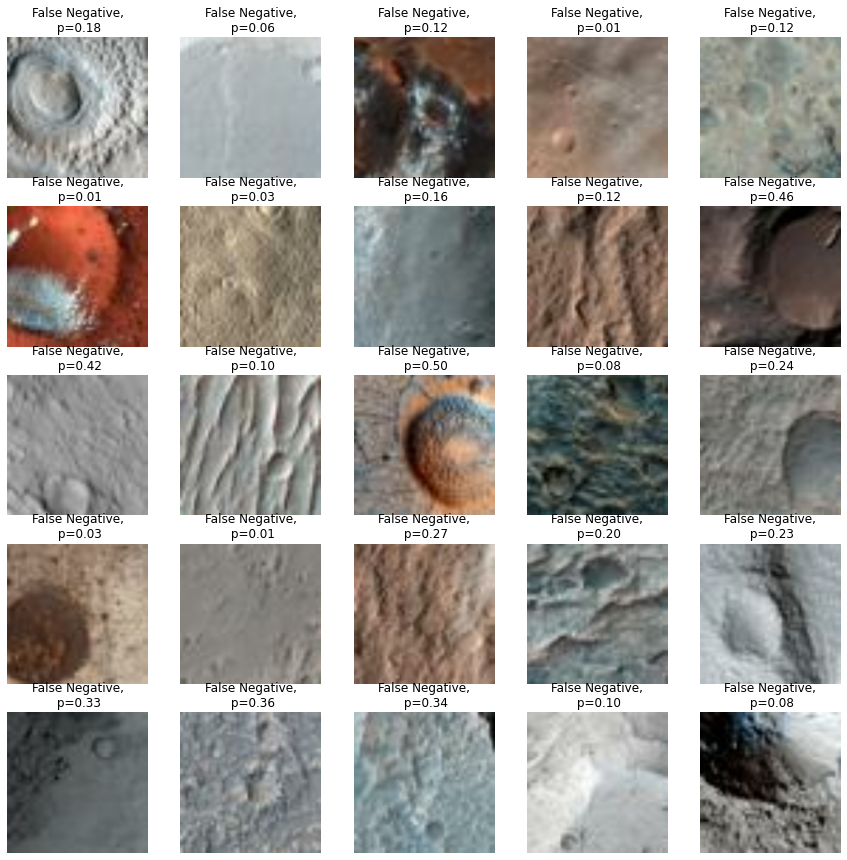

In [250]:
# inspect false negatives
plt.figure(figsize=(15, 15))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
#         ax.set_title(i)
    plt.imshow(false_negatives[i]['image'].numpy().astype("uint8"))
    pred_float = false_negatives[i]['pred']
    plt.title(f"False Negative,\n p={pred_float:.2f}",fontsize=12)
    plt.axis("off")

The bottom 3 of these look like hard cases. Really surprised case 4 was such a strong probability of not having a crater

In [215]:
true_positives = [] # will be a list of dictionaries with 
# each dictionary being: {'image':numpy array of the image,'pred':floating point prediction between 0 and 1}

for x, y in test_ds: # loop over batches
    new_predictions = best_model.predict(x)[:,0]
    new_labels = list(map(round,y.numpy()))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        pred_binary = round(pred_float)
        truth = new_labels[ii]
        if truth == 1 and pred_binary == 1:
            fn_dict = {'image':x[ii],'pred':pred_float}
            true_positives.append(fn_dict)

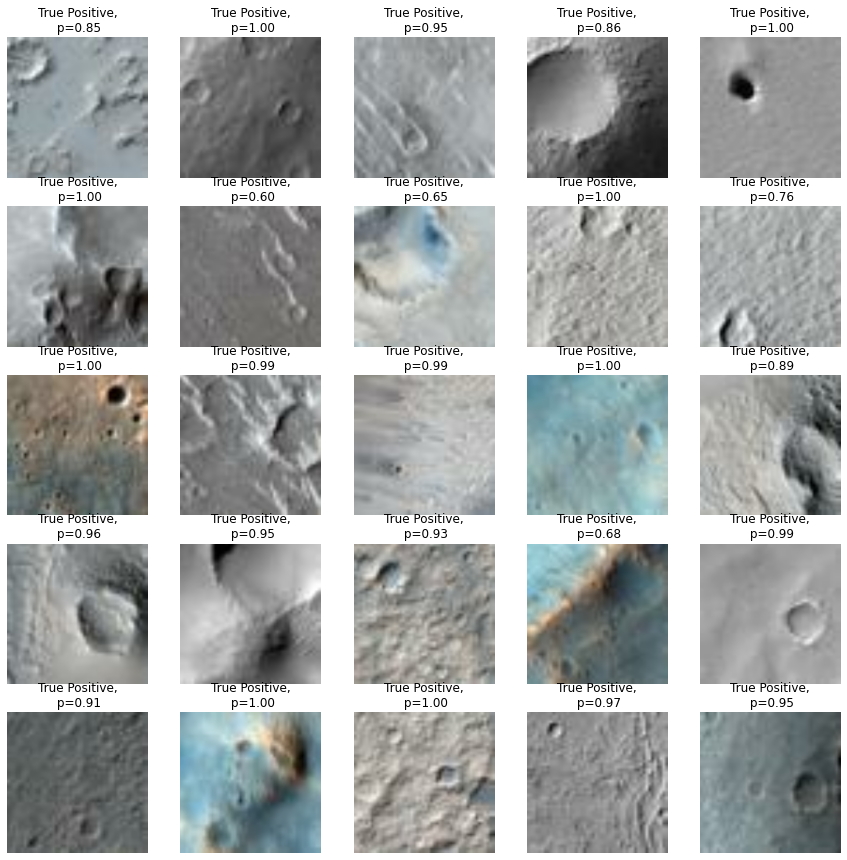

In [248]:
# inspect True positives
plt.figure(figsize=(15, 15))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
#         ax.set_title(i)
    plt.imshow(true_positives[i]['image'].numpy().astype("uint8"))
    pred_float = true_positives[i]['pred']
    plt.title(f"True Positive,\n p={pred_float:.2f}",fontsize=12)
    plt.axis("off")

It definitely does seem like the more obvious craters are detected. One thing I am noticing is that in the true positives the backgrounds are much more uniform. In the false negatives (fail to detect a crater that is there) the backgrounds are much more colorful. 

In [221]:
all_probabilities = [] 

for x, y in test_ds: # loop over batches
    new_predictions = best_model.predict(x)[:,0]
    new_labels = list(map(round,y.numpy()))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        all_probabilities.append(pred_float)

Text(0, 0.5, 'N')

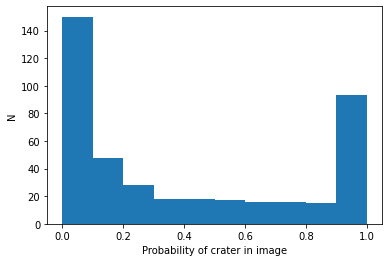

In [223]:
# Plot distribution of actual probabilities
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(all_probabilities)
ax.set_xlabel('Probability of crater in image')
ax.set_ylabel('N')

## ROC - AUC curve

In [234]:
roc_auc_score?

This is about what I got for the titanic survival challenge which isn't bad!

Let's look at some false positives.

In [251]:
false_positives = [] # will be a list of dictionaries with 
# each dictionary being: {'image':numpy array of the image,'pred':floating point prediction between 0 and 1}

for x, y in test_ds: # loop over batches
    new_predictions = best_model.predict(x)[:,0]
    new_labels = list(map(round,y.numpy()))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        pred_binary = round(pred_float)
        truth = new_labels[ii]
        if truth == 0 and pred_binary == 1:
            fn_dict = {'image':x[ii],'pred':pred_float}
            false_positives.append(fn_dict)

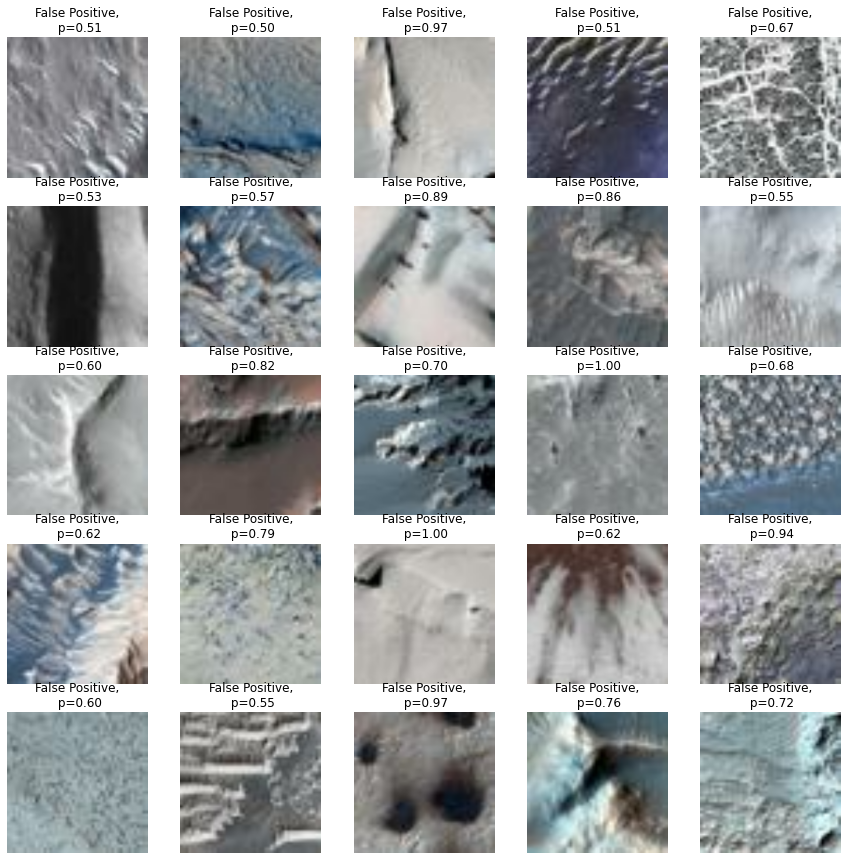

In [252]:
# inspect false positives
plt.figure(figsize=(15, 15))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
#         ax.set_title(i)
    plt.imshow(false_positives[i]['image'].numpy().astype("uint8"))
    pred_float = false_positives[i]['pred']
    plt.title(f"False Positive,\n p={pred_float:.2f}",fontsize=12)
    plt.axis("off")

These have a similar background color to the true positives, so it might be using background color here. Another reason to use grayscale instead of color images. 

In [253]:
true_negatives = [] # will be a list of dictionaries with 
# each dictionary being: {'image':numpy array of the image,'pred':floating point prediction between 0 and 1}

for x, y in test_ds: # loop over batches
    new_predictions = best_model.predict(x)[:,0]
    new_labels = list(map(round,y.numpy()))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        pred_binary = round(pred_float)
        truth = new_labels[ii]
        if truth == 0 and pred_binary == 0:
            fn_dict = {'image':x[ii],'pred':pred_float}
            true_negatives.append(fn_dict)

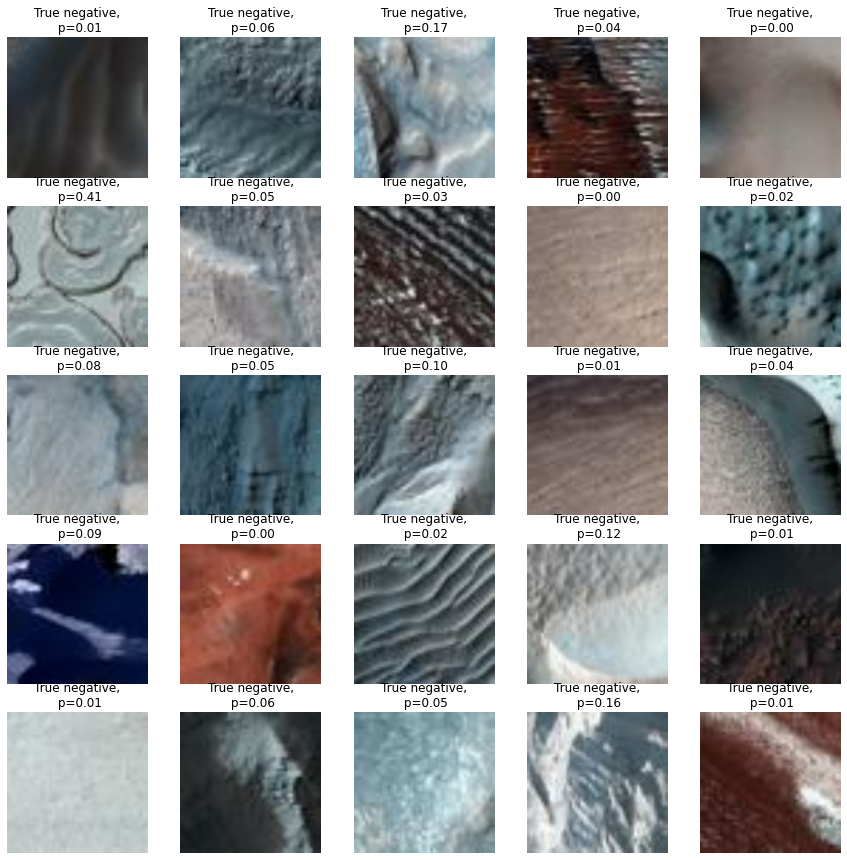

In [256]:
# inspect true negative
plt.figure(figsize=(15, 15))

for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
#         ax.set_title(i)
    plt.imshow(true_negatives[i]['image'].numpy().astype("uint8"))
    pred_float = true_negatives[i]['pred']
    plt.title(f"True negative,\n p={pred_float:.2f}",fontsize=12)
    plt.axis("off")

## Things to do
- Run the model on the rest of the dataset.
- A bigger training/validation set. It's pretty amazing it is doing as well as it is given the limited size of the training set I used.
- Try using grayscale images instead of color. Color might be throwing off the model. 
- Figure out how to do cross validation with this kind of model
- Keras tuner
- Try different CNN architectures
- Try use_multiprocessing=True in model.fit() to see if we get improvement
- Try different image sizes to see if that helps/hurts training
- Purify training/val set to only include obvious craters
- Learn how to look at the intermediate filters in my model

## Done
- Make a test set and evaluate the model on that -- Take a look at confusion matrix/ ROC-AUC curve
